In [1]:
import scanpy
import sctoolbox.receptor_ligand as rl
import sctoolbox.utilities as utils
from sctoolbox import settings
utils.settings_from_config("config.yaml", key="11")

Unable to determine R home: [Errno 2] No such file or directory: 'R'


[WARNING] Log file '../logs/11_log.txt' already exists. The file will be overwritten since 'overwrite_log' is set to True.


__Use `help(<function_name>)` for information on the parameters. E.g. `help(rl.download_db)`__

# Setup

## Load data
The dataset must be clustered for a receptor-ligand analysis.

In [2]:
adata = utils.load_h5ad("anndata_4.h5ad")
display(adata)

[INFO] The adata object was loaded from: ../adatas/anndata_4.h5ad


AnnData object with n_obs × n_vars = 2735 × 21135
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'doublet_score', 'predicted_doublet', 'predicted_sex', 'n_genes', 'log1p_n_genes', 'S_score', 'G2M_score', 'phase', 'leiden', 'LISI_score_X_pca', 'LISI_score_X_umap', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_0.5_recluster', 'clustering'
    var: 'is_ribo', 'is_mito', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cluster

## Input

In [11]:
# Path to receptor ligand database
db_path = f'http://tcm.zju.edu.cn/celltalkdb/download/processed_data/human_lr_pair.txt'

# Comput interactions
cluster_col = "clustering"
normalize = 1000 # Correct clusters to given size.
gene_col = None # Column that holds gene name /id. Set to None to use index
overwrite = False # Overwrite existing interaction table

# Plotting

dpi = 100

## Violin
violin_min_perc = 0 # Minimum percentage of cells in a cluster that express the respective gene.
violin_out_suffix = "violin" # Suffix of output file
violin_figsize = (5, 30) # Figure size

## Network
net_min_perc = 0 # Minimum percentage of cells in a cluster that express the respective gene.
net_interaction_score = 0 # Interaction score must be above this threshold for the interaction to be counted in the graph.
net_interaction_perc = 90 # Select interaction scores above or equal to the given percentile. Will overwrite parameter interaction_score.
net_out_suffix = "network" # Suffix of output file
net_title = None # Plot title
net_color_min = 0 # Min value for color range
net_color_max = None # May value for color range
net_restrict_to = [] # Only show given clusters provided in list.
net_show_count = True # Show the interaction count

## Connection plot
con_restrict_to = None # Restrict plot to given cluster names.
con_figsize = (5, 10) # Figure size
con_out_suffix="connectionPlot" # Suffix of output file
con_title = None # Plot title
con_filter = "receptor_score > 2 & ligand_score > 2 & interaction_score > 5" # Conditions to filter the interaction table
con_lw_multiplier = 2 # Linewidth multiplier
con_wspace = 0.4 # Width between plots

## Filter for interaction table
tab_min_perc = 0
tab_interaction_score = 0
tab_interaction_perc = 90
tab_out_suffix = "interaction_table"
group_a = None
group_b = None

## Download receptor-ligand database
Provide a path to a table with receptor-ligand interactions. Will be stored in the adata object (`adata.uns['receptor-ligand]['database']`).

In [4]:
rl.download_db(adata=adata,
               db_path=db_path,
               ligand_column='ligand_gene_symbol',
               receptor_column='receptor_gene_symbol',
               inplace=True,
               overwrite=False)

## Compute interactions
Create a table of receptor-ligand interactions between given groups. This table is used for plotting. Will be stored in the adata object (`adata.uns['receptor-ligand']['interactions']`)

In [5]:
rl.calculate_interaction_table(adata=adata,
                               cluster_column=cluster_col,
                               gene_index=gene_col,
                               normalize=normalize,
                               inplace=True,
                               overwrite=overwrite)

finding receptor-ligand interactions: 100%|██████████| 3398/3398 [00:05<00:00, 632.04it/s]


# Plotting

## Violin
Show the distribution of interaction scores for all group combinations.

Scores `> 0` can be interpreted as receptor-ligand interactions enriched for group combination.  
Scores `< 0` can be interpreted as receptor-ligand interactions depleted for group combination.

array([<AxesSubplot: title={'center': 'Cluster 1'}, xlabel='Cluster', ylabel='interaction_score'>,
       <AxesSubplot: title={'center': 'Cluster 2'}, xlabel='Cluster', ylabel='interaction_score'>,
       <AxesSubplot: title={'center': 'Cluster 3'}, xlabel='Cluster', ylabel='interaction_score'>,
       <AxesSubplot: title={'center': 'Cluster 4'}, xlabel='Cluster', ylabel='interaction_score'>,
       <AxesSubplot: title={'center': 'Cluster 5'}, xlabel='Cluster', ylabel='interaction_score'>,
       <AxesSubplot: title={'center': 'Cluster 6'}, xlabel='Cluster', ylabel='interaction_score'>,
       <AxesSubplot: title={'center': 'Cluster 7'}, xlabel='Cluster', ylabel='interaction_score'>,
       <AxesSubplot: title={'center': 'Cluster 8'}, xlabel='Cluster', ylabel='interaction_score'>,
       <AxesSubplot: title={'center': 'Cluster 9'}, xlabel='Cluster', ylabel='interaction_score'>],
      dtype=object)

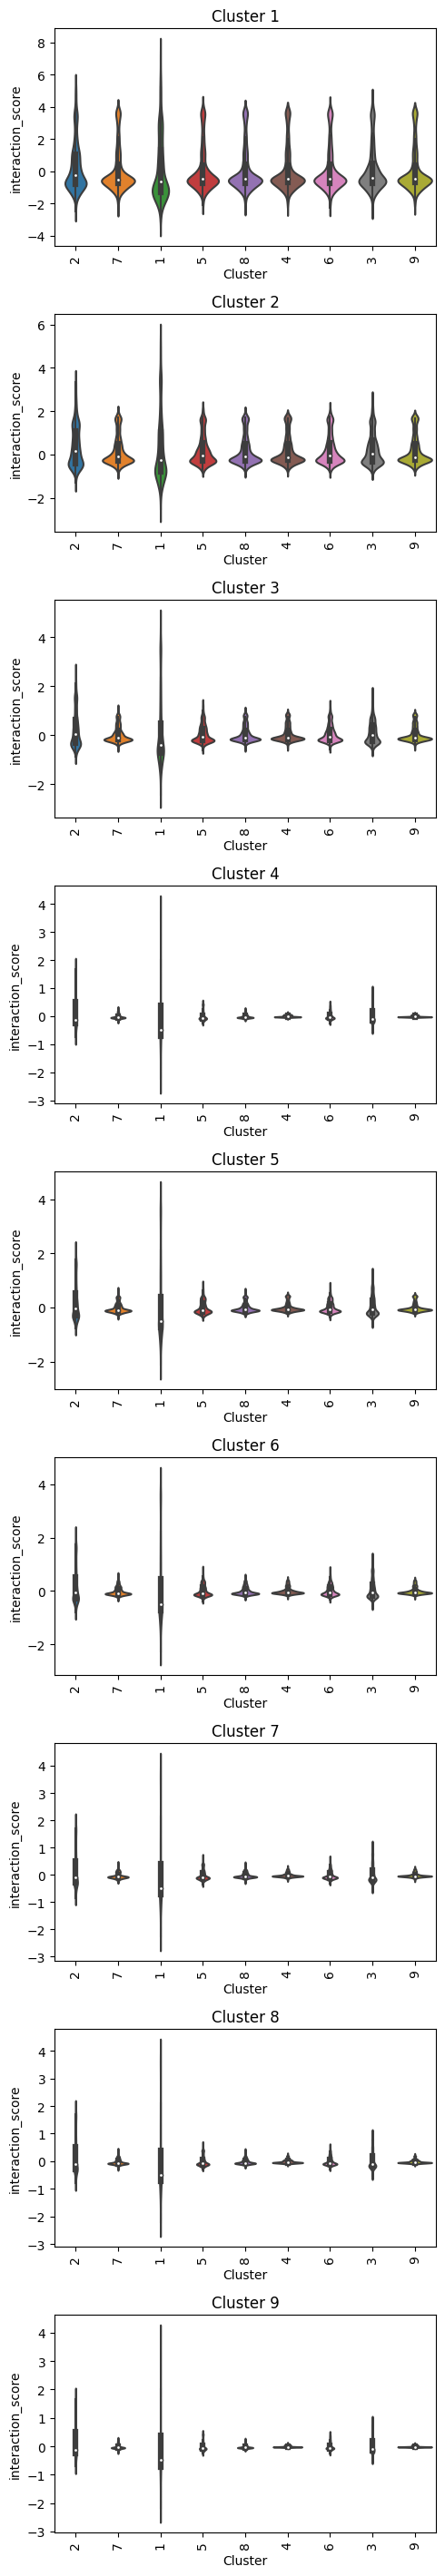

In [6]:
rl.interaction_violin_plot(adata,
                           min_perc=violin_min_perc,
                           save=f"rl_{violin_out_suffix}.pdf",
                           figsize=violin_figsize,
                           dpi=dpi)

## Network
Show a network graph of number of interactions between groups.

Max weight 1145


array([<AxesSubplot: >,
       <AxesSubplot: title={'center': 'Interaction count'}>], dtype=object)

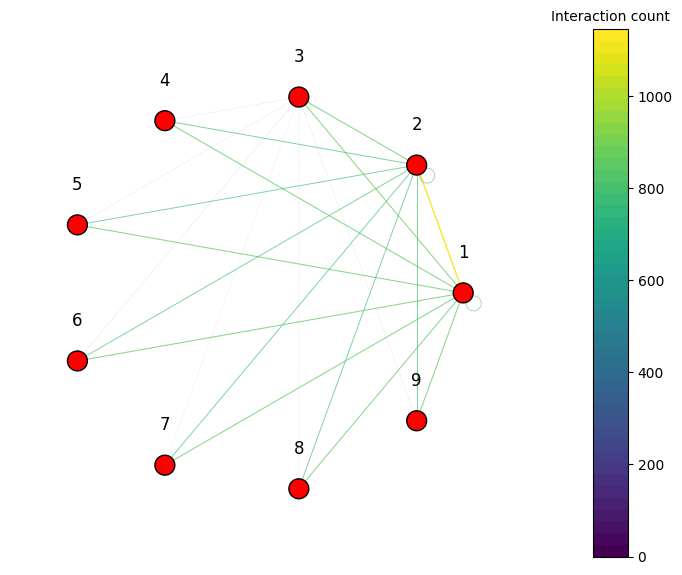

In [7]:
rl.hairball(adata,
            min_perc=net_min_perc,
            interaction_score=net_interaction_score,
            interaction_perc=net_interaction_perc,
            save=f"rl_{net_out_suffix}.pdf",
            title=net_title,
            color_min=net_color_min,
            color_max=net_color_max,
            restrict_to=net_restrict_to,
            show_count=net_show_count
           )

## Receptor-ligand connections
Show a detailed view on receptor-ligand pairs and their strength between groups.

- __receptor-/ ligand score__: Gene enriched (`> 0`) or depleted (`< 0`) for specific group.
- __receptor-/ ligand percent__: Percent of cells in a group expressing gene.
- __interaction score__: receptor-ligand pair enriched (`> 0`) or depleted (`< 0`) between groups.

array([<AxesSubplot: title={'center': 'Receptor'}, xlabel='Cluster'>,
       <AxesSubplot: title={'center': 'Ligand'}, xlabel='Cluster'>],
      dtype=object)

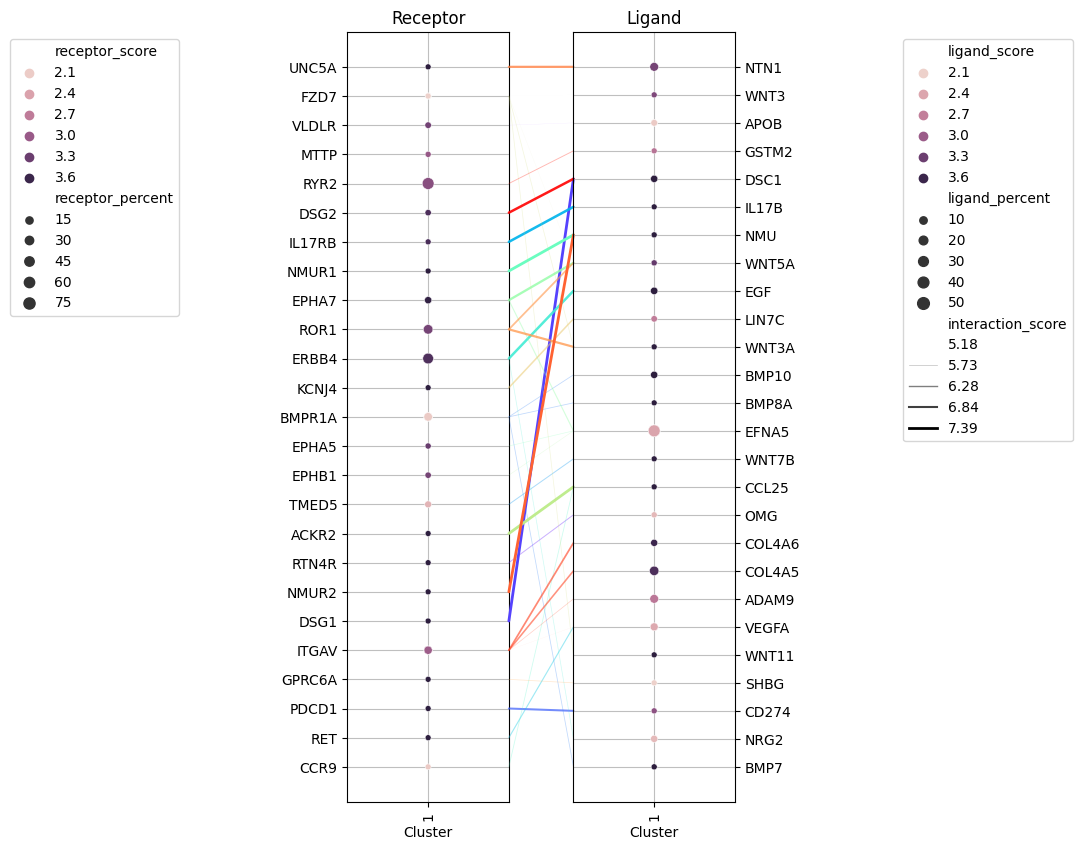

In [12]:
rl.connectionPlot(adata=adata, 
                  restrict_to=con_restrict_to,
                  figsize=con_figsize,
                  dpi=dpi,
                  connection_alpha="interaction_score",
                  save=f"rl_{con_out_suffix}.pdf",
                  title=con_title,
                  receptor_cluster_col="receptor_cluster",
                  receptor_col="receptor_gene",
                  receptor_hue="receptor_score",
                  receptor_size="receptor_percent",
                  ligand_cluster_col="ligand_cluster",
                  ligand_col="ligand_gene",
                  ligand_hue="ligand_score",
                  ligand_size="ligand_percent",
                  filter=con_filter,
                  lw_multiplier=con_lw_multiplier,
                  wspace=con_wspace,
                  line_colors="rainbow")

## Get interaction table

In [13]:
interaction_table = rl.get_interactions(adata,
                                        min_perc = tab_min_perc,
                                        interaction_score = tab_interaction_score,
                                        interaction_perc = tab_interaction_perc,
                                        group_a = group_a,
                                        group_b = group_b,
                                        save = f"rl_{tab_out_suffix}.tsv")